<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fmachine_learning/SI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/1909.00125.pdf
* https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Imports

In [95]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
#--------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
#--------------------------------------------------
from skimage import io, color
from skimage.feature import hog,local_binary_pattern,sift,ORB,graycomatrix, graycoprops,match_descriptors
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
#--------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow.keras.metrics as metrics
#------------------------------------------------
import joblib

In [2]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helpers

In [4]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [5]:
def extract_file(zip_path,specified_directory):
  # create a ZipFile object
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all contents to a specified directory
    zip_ref.extractall(specified_directory)


In [6]:
def read_images_gray( flooded_path,non_flooded_path,image_size):
    flooded = np.empty((0, image_size, image_size))
    non_flooded = np.empty((0, image_size, image_size))
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

   
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded


In [7]:
def read_images_rgb( flooded_path,non_flooded_path,image_size):
    flooded = np.empty((0, image_size, image_size, 3))
    non_flooded = np.empty((0, image_size, image_size, 3))

    
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0) 
        flooded = np.concatenate((flooded, img), axis=0)

   
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [8]:
def show_images(images,images_labels,is_gray=True):
  if is_gray:
    Cmap='gray'
  else:
    Cmap=None
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic,cmap=Cmap)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

In [9]:
def evaluate(y_train,y_train_pred,y_test,y_test_pred,model_name):
    print(f"Model: {model_name}")
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    cr_train = classification_report(y_train, y_train_pred,zero_division=1.0)
    cr_test = classification_report(y_test, y_test_pred,zero_division=1.0)
    fn_train = cm_train[1][0]
    fn_test = cm_test[1][0]
    pos_train = cm_train[1][0] + cm_train[1][1]
    pos_test = cm_test[1][0] + cm_test[1][1]
    omission_error_train = fn_train / pos_train
    omission_error_test = fn_test / pos_test
    fp_train = cm_train[0][1]
    fp_test = cm_test[0][1]
    neg_train = cm_train[0][0] + cm_train[0][1]
    neg_test = cm_test[0][0] + cm_test[0][1]
    commission_error_train = fp_train / neg_train
    commission_error_test = fp_test / neg_test
    print("Train")
    print(cm_train)
    print(cr_train)
    print("Omission error rate:", omission_error_train)
    print("Commission error rate:", commission_error_train)
    print("Test")
    print(cm_test)
    print(cr_test)
    print("Omission error rate:", omission_error_test)
    print("Commission error rate:", commission_error_test)
    

# Images reading 

In [10]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [11]:
flooded,non_flooded=read_images_rgb("dataset/flooded","dataset/non-flooded",256)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 256, 256, 3)
non_flooded images shapes (461, 256, 256, 3)


In [12]:
def split_data(shuffle=False,stratify=False):
  stratify_1=None
  stratify_2=None
  X = np.concatenate((flooded, non_flooded), axis=0)
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  # 80% training, 10% validation, 10% testing
  if stratify:
    stratify_1=y
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1)
  if stratify:
      stratify_2=y_test
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=shuffle,stratify=stratify_2)
  return X_train, X_test,X_val, y_train, y_test,y_val
     

In [13]:
X_train, X_test,X_val, y_train, y_test,y_val=split_data(shuffle=True,stratify=True)
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)  
print(X_val.shape, y_val.shape)  

(737, 256, 256, 3) (737,)
(93, 256, 256, 3) (93,)
(92, 256, 256, 3) (92,)


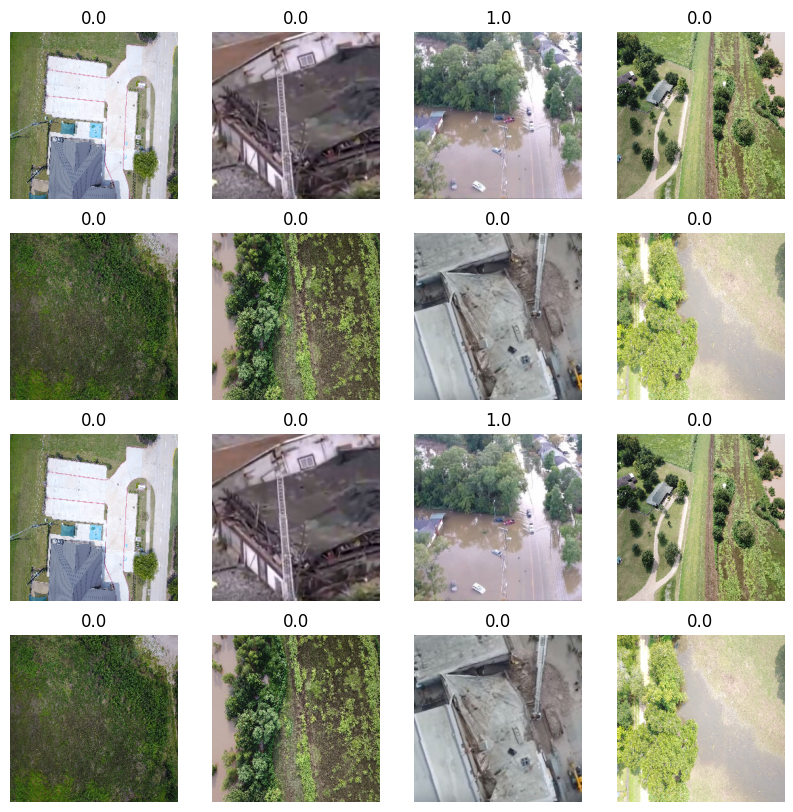

In [14]:
show_images(X_train,y_train,is_gray=False)

# Machine-learning approach

* Traditional machine learning models, such as logistic regression, SVM, or decision trees, can have high overfitting problems in image classification tasks because they lack the ability to learn complex hierarchical representations of the image data. These models typically use hand-crafted features, such as color histograms or texture descriptors, as input to the model. These features are often designed to capture specific characteristics of the image data, but may not be sufficient to capture all the relevant information needed for accurate classification.

# Feature Extraction

## Color-based features

In [15]:
def convert_to_other_color_models(image):
    #The cvtColor function expects the input image to have a 
    #depth of 8-bit unsigned integer (CV_8U) or 32-bit floating-point (CV_32F).
    image = np.uint8(image * 255)
    # Convert the RGB image to different color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return hsv,lab,ycrcb

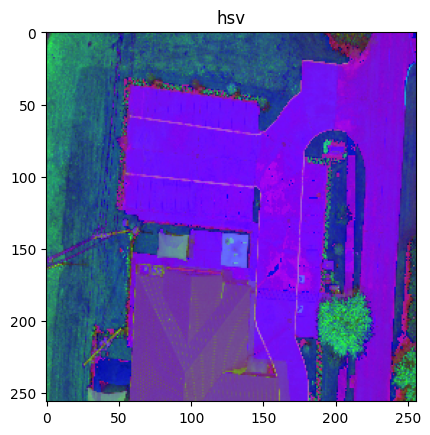

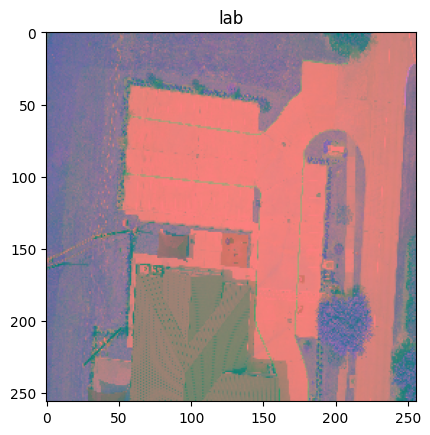

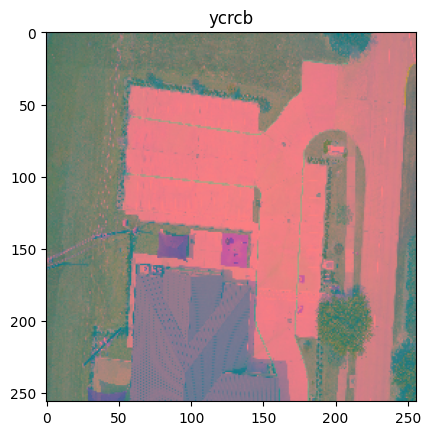

In [16]:
hsv,lab,ycrcb=convert_to_other_color_models(X_train[0])
show_img(hsv,"hsv")
show_img(lab,"lab")
show_img(ycrcb,"ycrcb")

### Calculate mean and standard deviation

In [17]:
def calc_mean_std(img_hsv,img_lab,img_ycrcb):
    #calc mean and standard deviation
    hsv_mean, hsv_std = cv2.meanStdDev(img_hsv)
    lab_mean, lab_std = cv2.meanStdDev(img_lab)
    ycrcb_mean, ycrcb_std = cv2.meanStdDev(img_ycrcb)
    hsv_mean, hsv_std = hsv_mean.flatten(), hsv_std.flatten()
    lab_mean, lab_std = lab_mean.flatten(), lab_std.flatten()
    ycrcb_mean, ycrcb_std = ycrcb_mean.flatten(), ycrcb_std.flatten()
    return hsv_mean, hsv_std, lab_mean, lab_std, ycrcb_mean, ycrcb_std

### Calculate histograms

In [18]:
def calc_histograms(img_hsv,img_lab,img_ycrcb):
    #calc histogram
    hsv_hist = cv2.calcHist([img_hsv], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    lab_hist = cv2.calcHist([img_lab], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
    ycrcb_hist = cv2.calcHist([img_ycrcb], [0, 1, 2], None, [16,16, 16], [0, 256, 0, 256, 0, 256])
    # Normaliz to sum up to 1
    hsv_hist = cv2.normalize(hsv_hist, hsv_hist).flatten()
    lab_hist = cv2.normalize(lab_hist, lab_hist).flatten()
    ycrcb_hist = cv2.normalize(ycrcb_hist, ycrcb_hist).flatten()
    return hsv_hist,lab_hist,ycrcb_hist

In [19]:
def extract_color_features(image):
   hsv,lab,ycrcb=convert_to_other_color_models(image)
   hsv_mean, hsv_std, lab_mean, lab_std, ycrcb_mean, ycrcb_std=calc_mean_std(hsv,lab,ycrcb)
   hsv_hist,lab_hist,ycrcb_hist=calc_histograms(hsv,lab,ycrcb)
   color_features = np.concatenate([hsv_mean, hsv_std, lab_mean, lab_std, ycrcb_mean, ycrcb_std, hsv_hist, lab_hist, ycrcb_hist])
   return color_features

In [20]:
print(extract_color_features(X_train[0]).shape)

(12306,)


In [21]:
train_color_features=[extract_color_features(img) for img in X_train] 
test_color_features=[extract_color_features(img) for img in X_test] 
val_color_features=[extract_color_features(img) for img in X_val] 
train_color_features = np.array(train_color_features)
test_color_features = np.array(test_color_features)
val_color_features = np.array(val_color_features)

In [22]:
print("Train color features shape:", train_color_features.shape)
print("Test color features shape:", test_color_features.shape)
print("Validation color features shape:", val_color_features.shape)

Train color features shape: (737, 12306)
Test color features shape: (93, 12306)
Validation color features shape: (92, 12306)


## Texture-based features

In [23]:
def longest_feature_vector(features):
    max_length = 0
    # Determine maximum length of feature vectors
    for feature_vector in features:
        length = len(feature_vector)
        if length > max_length:
            max_length = length
    return max_length

In [24]:
def padding_shorter_features_vector(max_length,features):
    # Pad shorter feature vectors with zeros
    padded_features = []
    for feature_vector in features:
        length = len(feature_vector)
        if length < max_length:
            padding = np.zeros(max_length - length)
            padded_feature_vector = np.concatenate([feature_vector, padding])
            padded_features.append(padded_feature_vector)
        else:
            padded_features.append(feature_vector)

    # Convert list of feature vectors to multi-dimensional NumPy array
    features_np = np.array(padded_features)
    return features_np

### oriented fast rotated brief(ORB)

In [25]:
def oriented_fast_rotated_brief(gray,n_keypoints=200):
    '''
    ORB (Oriented FAST and Rotated BRIEF)
    keypoints are specific points in an image that are detected by the algorithm
    and used as the basis for feature extraction.Keypoints are locations in an image
    that are distinctive and invariant to scale,rotation, and illumination changes.
    '''
    descriptor_extractor = ORB(n_keypoints=200)
    descriptor_extractor.detect_and_extract(gray)
    keypoints = descriptor_extractor.keypoints.flatten()
    descriptors = descriptor_extractor.descriptors.astype('float32').flatten()
    return keypoints,descriptors

### local binary pattern(LBP)

In [26]:
def func_local_binary_pattern(gray):
  # Compute Local Binary Pattern (LBP) features
  lbp = local_binary_pattern(gray, 8, 1)
  lbp_hist, _ = np.histogram(lbp, bins=256, range=(0, 255))
  return lbp_hist.flatten()

### gray level cooccurrence matrix(GLCM)

In [27]:
def gray_level_cooccurrence_matrix(gray):
    # Compute Gray Level Co-occurrence Matrix (GLCM) features
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    return contrast, homogeneity, energy, correlation

### histogram of gradients(HOG)

In [28]:
def histogram_of_gradients(gray):
  hog_feature_descriptor = hog(gray, orientations=8, pixels_per_cell=(16, 16))
  return hog_feature_descriptor.flatten()

In [29]:
def extract_texture_features(image):
    image = np.uint8(image * 255)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    keypoints,descriptors=oriented_fast_rotated_brief(gray)
    lbp_hist=func_local_binary_pattern(gray)
    contrast, homogeneity, energy, correlation=gray_level_cooccurrence_matrix(gray)
    hog_feature_descriptor=histogram_of_gradients(gray)
    texture_features = np.concatenate([keypoints,descriptors,lbp_hist,contrast, homogeneity, energy, correlation,hog_feature_descriptor])
    return texture_features

In [30]:
train_texture_features=[extract_texture_features(img) for img in X_train]
test_texture_features=[extract_texture_features(img) for img in X_test]
val_texture_features=[extract_texture_features(img) for img in X_val]

In [31]:
train_longest_feature_vector=longest_feature_vector(train_texture_features)
train_texture_features_padded=padding_shorter_features_vector(train_longest_feature_vector,train_texture_features)

test_longest_feature_vector=longest_feature_vector(test_texture_features)
test_texture_features_padded=padding_shorter_features_vector(test_longest_feature_vector,test_texture_features)

val_longest_feature_vector=longest_feature_vector(val_texture_features)
val_texture_features_padded=padding_shorter_features_vector(val_longest_feature_vector,val_texture_features)

In [32]:
print("Padded train texture features shape:", train_texture_features_padded.shape)
print("Padded test texture features shape:", test_texture_features_padded.shape)
print("Padded validation texture features shape:", val_texture_features_padded.shape)

Padded train texture features shape: (737, 65984)
Padded test texture features shape: (93, 65984)
Padded validation texture features shape: (92, 65984)


## Concatenate Features and feature selection

### Raw data

In [33]:
flatten_X_train = X_train.reshape(X_train.shape[0], -1)
flatten_X_test = X_test.reshape(X_test.shape[0], -1)
flatten_X_val = X_val.reshape(X_val.shape[0], -1)

In [34]:
print("Flattened X_train shape:", flatten_X_train.shape)
print("Flattened X_test shape:", flatten_X_test.shape)
print("Flattened X_val shape:", flatten_X_val.shape)

Flattened X_train shape: (737, 196608)
Flattened X_test shape: (93, 196608)
Flattened X_val shape: (92, 196608)


In [35]:
pca = PCA(n_components=0.95)
pca.fit(flatten_X_train)


pca_X_train = pca.transform(flatten_X_train)
pca_X_test = pca.transform(flatten_X_test)
pca_X_val = pca.transform(flatten_X_val)

In [36]:
print("PCA-transformed X_train shape:", pca_X_train.shape)
print("PCA-transformed X_test shape:", pca_X_test.shape)
print("PCA-transformed X_val shape:", pca_X_val.shape)

PCA-transformed X_train shape: (737, 445)
PCA-transformed X_test shape: (93, 445)
PCA-transformed X_val shape: (92, 445)


In [37]:
raw_input_dim=pca_X_train.shape[1]

### Extracted Features

In [38]:
train_features=np.concatenate([train_color_features,train_texture_features_padded],axis=1)
test_features=np.concatenate([test_color_features,test_texture_features_padded],axis=1)
val_features=np.concatenate([val_color_features,val_texture_features_padded],axis=1)

In [39]:
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)
print("Validation features shape:", val_features.shape)

Train features shape: (737, 78290)
Test features shape: (93, 78290)
Validation features shape: (92, 78290)


In [40]:
pca = PCA(n_components=0.95)
pca.fit(train_features)


pca_train_features = pca.transform(train_features)
pca_test_features = pca.transform(test_features)
pca_val_features = pca.transform(val_features)

In [41]:
# Print shape of PCA-transformed features
print("PCA-transformed train features shape:", pca_train_features.shape)
print("PCA-transformed test features shape:", pca_test_features.shape)
print("PCA-transformed validation features shape:", pca_val_features.shape)

PCA-transformed train features shape: (737, 18)
PCA-transformed test features shape: (93, 18)
PCA-transformed validation features shape: (92, 18)


In [47]:
features_input_dim=pca_train_features.shape[1]

# Models

In [98]:
def run_2_layer_nn(input_dim,X_train,X_val,X_test,model_name,
                   regularizers_l2=0.01,dropout=0.7,
                   early_stopping_monitor='val_loss',patience_val=3,
                   optimizer_name='adam',mat=metrics.AUC(),
                   epochs_num=10,batch_size=32):

  model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizers_l2), input_dim=input_dim),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
  ])

  early_stopping = EarlyStopping(monitor=early_stopping_monitor, patience=patience_val)

  model.compile(loss='binary_crossentropy', optimizer=optimizer_name, metrics=[mat])


  history = model.fit(X_train, y_train, epochs=epochs_num, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])


  y_train_pred = model.predict(X_train).round()
  y_test_pred = model.predict(X_test).round()
  evaluate(y_train, y_train_pred, y_test, y_test_pred,model_name)
  joblib.dump(model, f'/content/{model_name}' + '.joblib')


In [99]:
def apply_model(model, model_name,X_train, X_test,cv=5, **kwargs):
    model_obj = model(**kwargs)
    model_obj.fit(X_train, y_train)
    scores = cross_validate(model_obj, X_train, y_train, cv=cv, return_train_score=True)

    train_scores = scores['train_score']
    test_scores = scores['test_score']
    train_accuracy = train_scores.mean()
    train_accuracy_variance=train_scores.var()
    test_accuracy = test_scores.mean()
    test_accuracy_variance=test_scores.var()

    print('Train accuracy:', train_accuracy)
    print('Train accuracy variance:', train_accuracy_variance)

    print('Test accuracy:', test_accuracy)
    print('Test accuracy variance:', test_accuracy_variance)

    y_train_pred = model_obj.predict(X_train)
    y_test_pred = model_obj.predict(X_test)
    evaluate(y_train, y_train_pred, y_test, y_test_pred, model_name)
    joblib.dump(model_obj, f'/content/{model_name}' + '.joblib')


## 2-layer neural network

### Raw data

In [100]:
run_2_layer_nn(raw_input_dim,pca_X_train,pca_X_val,pca_X_test,'2-layer NN on row data')

Epoch 1/10
24/24 [==============================] - 1s 15ms/step - loss: 4.9800 - auc_2: 0.5289 - val_loss: 2.6405 - val_auc_2: 0.6134
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 3.9696 - auc_2: 0.6227 - val_loss: 2.4012 - val_auc_2: 0.6283
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 3.1860 - auc_2: 0.6613 - val_loss: 2.2721 - val_auc_2: 0.6316
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 2.8901 - auc_2: 0.7072 - val_loss: 2.1483 - val_auc_2: 0.6418
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 2.4588 - auc_2: 0.7306 - val_loss: 2.1021 - val_auc_2: 0.6522
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 2.0526 - auc_2: 0.8012 - val_loss: 2.0282 - val_auc_2: 0.6538
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 1.9264 - auc_2: 0.8089 - val_loss: 1.9528 - val_auc_2: 0.6567
Epoch 8/10
24/24 [==============================] - 0s 5ms/st

### Features

In [101]:
run_2_layer_nn(features_input_dim,pca_train_features,pca_val_features,pca_test_features,'2-layer NN on Features')

Epoch 1/10
24/24 [==============================] - 1s 17ms/step - loss: 339.1072 - auc_2: 0.6097 - val_loss: 63.6501 - val_auc_2: 0.7391
Epoch 2/10
24/24 [==============================] - 0s 7ms/step - loss: 245.8642 - auc_2: 0.6826 - val_loss: 93.4844 - val_auc_2: 0.7316
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 245.5685 - auc_2: 0.6930 - val_loss: 91.2198 - val_auc_2: 0.7391
Epoch 4/10
3/3 [==============================] - 0s 4ms/step
Model: 2-layer NN on Features
Train
[[300  68]
 [ 62 307]]
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       368
         1.0       0.82      0.83      0.83       369

    accuracy                           0.82       737
   macro avg       0.82      0.82      0.82       737
weighted avg       0.82      0.82      0.82       737

Omission error rate: 0.16802168021680217
Commission error rate: 0.18478260869565216
Test
[[37 10]
 [ 6 40]]
              precision    recal

## Random forest

### Raw data

In [102]:
apply_model(RandomForestClassifier,'Random Forest on row data',pca_X_train,pca_X_test,max_depth=5, n_estimators=200,min_samples_leaf=5)

Train accuracy: 0.9986434922736036
Train accuracy variance: 1.6091246326619539e-06
Test accuracy: 0.6852914138628424
Test accuracy variance: 0.001433608321560412
Model: Random Forest on row data
Train
[[365   3]
 [  1 368]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       368
         1.0       0.99      1.00      0.99       369

    accuracy                           0.99       737
   macro avg       0.99      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

Omission error rate: 0.0027100271002710027
Commission error rate: 0.008152173913043478
Test
[[26 21]
 [ 9 37]]
              precision    recall  f1-score   support

         0.0       0.74      0.55      0.63        47
         1.0       0.64      0.80      0.71        46

    accuracy                           0.68        93
   macro avg       0.69      0.68      0.67        93
weighted avg       0.69      0.68      0.67        93

Omission er

### Extracted features

In [103]:
apply_model(RandomForestClassifier,'Random Forest on Extracted features',pca_train_features,pca_test_features,max_depth=5, n_estimators=200,min_samples_leaf=5)

Train accuracy: 0.9358878881183277
Train accuracy variance: 2.240933196337193e-05
Test accuracy: 0.886036036036036
Test accuracy variance: 0.00031861808790340884
Model: Random Forest on Extracted features
Train
[[348  20]
 [ 32 337]]
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93       368
         1.0       0.94      0.91      0.93       369

    accuracy                           0.93       737
   macro avg       0.93      0.93      0.93       737
weighted avg       0.93      0.93      0.93       737

Omission error rate: 0.08672086720867209
Commission error rate: 0.05434782608695652
Test
[[44  3]
 [ 4 42]]
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93        47
         1.0       0.93      0.91      0.92        46

    accuracy                           0.92        93
   macro avg       0.93      0.92      0.92        93
weighted avg       0.92      0.92      0.92        93

Omis

## SVM

### Raw data

In [106]:
apply_model(SVC,"SVC on raw data",pca_X_train,pca_X_test,C=0.001, kernel='linear')

Train accuracy: 0.9606480389053551
Train accuracy variance: 4.559489112114058e-05
Test accuracy: 0.7109762824048539
Test accuracy variance: 0.002237357577756284
Model: SVC on raw data
Train
[[345  23]
 [ 13 356]]
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       368
         1.0       0.94      0.96      0.95       369

    accuracy                           0.95       737
   macro avg       0.95      0.95      0.95       737
weighted avg       0.95      0.95      0.95       737

Omission error rate: 0.03523035230352303
Commission error rate: 0.0625
Test
[[30 17]
 [12 34]]
              precision    recall  f1-score   support

         0.0       0.71      0.64      0.67        47
         1.0       0.67      0.74      0.70        46

    accuracy                           0.69        93
   macro avg       0.69      0.69      0.69        93
weighted avg       0.69      0.69      0.69        93

Omission error rate: 0.260869565217391

### Extracted features

In [107]:
apply_model(SVC,"SVC on Extracted features",pca_train_features,pca_test_features,C=0.001, kernel='linear')

Train accuracy: 0.8710989611809732
Train accuracy variance: 5.0575568011964235e-05
Test accuracy: 0.8493473064901635
Test accuracy variance: 0.00020372162520141415
Model: SVC on Extracted features
Train
[[330  38]
 [ 57 312]]
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       368
         1.0       0.89      0.85      0.87       369

    accuracy                           0.87       737
   macro avg       0.87      0.87      0.87       737
weighted avg       0.87      0.87      0.87       737

Omission error rate: 0.15447154471544716
Commission error rate: 0.10326086956521739
Test
[[41  6]
 [ 8 38]]
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85        47
         1.0       0.86      0.83      0.84        46

    accuracy                           0.85        93
   macro avg       0.85      0.85      0.85        93
weighted avg       0.85      0.85      0.85        93

Omission err